In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import RidgeCV
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data_path = '../../data/cleaned/UCB_dept_merge.csv'

### Modified data
The first step was to select a subset of useful columns, and do some early data processing to have a reasonable data set.

In [4]:
# Parsing date columns allows us to do some nifty things with pandas
date_columns = ['po_closed_date', 'creation_date']

In [5]:
data = pd.read_csv(data_path, parse_dates=date_columns)

In [13]:
data['cost_total'] = data.unit_price * data.quantity

# Time analysis

In [42]:
groupby = ['creation_date', 'department_name']
# week_counts = data.groupby(groupby).count() # Number of POs per department
week_counts = data.groupby(groupby).mean() # Mean/med cost per department

week_counts = week_counts['cost_total'].unstack(groupby[-1])\
    .resample('w', how='sum')
week_counts['week'] = week_counts.index.week

In [43]:
week_sums = week_counts.groupby('week').sum().replace(np.nan, 0)
week_mean = week_sums.mean(1)
week_ste = week_sums.std(1) / np.sqrt((week_sums != 0).sum(1))

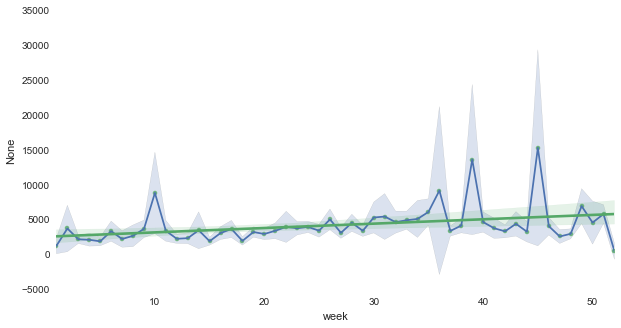

In [44]:
ax = week_mean.plot(figsize=(10, 5))
ax.fill_between(week_ste.index, week_mean-week_ste, week_mean+week_ste,
                alpha=.2)
sns.regplot(week_mean.index.values, week_mean, ax=ax)

In [47]:
# Similarities in time for depts
null_cut = 5
keep_cols = (week_sums == 0).sum(0) < null_cut
week_sums_active = week_sums.loc[:, keep_cols]
week_sums_normalized = week_sums_active / week_sums_active.max(0)

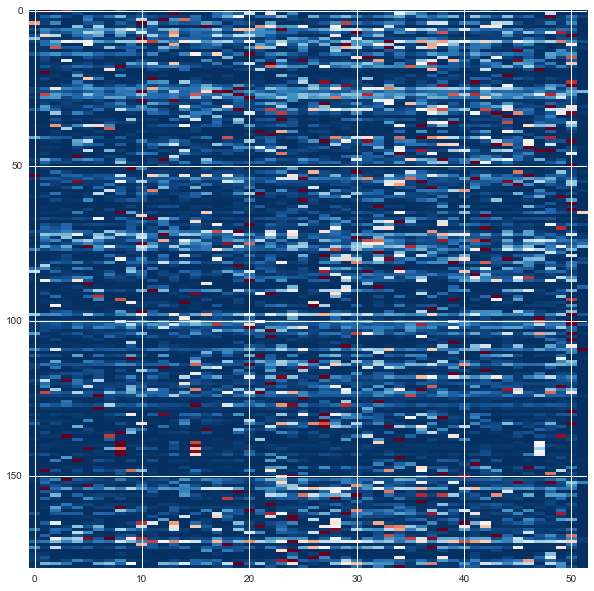

In [48]:
f, ax = plt.subplots(figsize=(10, 10))
ax.imshow(week_sums_normalized.T, cmap=plt.cm.RdBu_r,
          aspect='auto', interpolation='nearest')

In [49]:
from sklearn import cluster, metrics

In [50]:
# clust = cluster.KMeans()
clust = cluster.AffinityPropagation()
# clust = cluster.SpectralClustering()
# clust = cluster.AgglomerativeClustering(n_clusters=20)

In [51]:
X = week_sums_normalized.T.values
# X = week_sums_active.T.values
try:
    clust.fit(X)
    labels = clust.predict(X)
except:
    labels = clust.fit_predict(X)

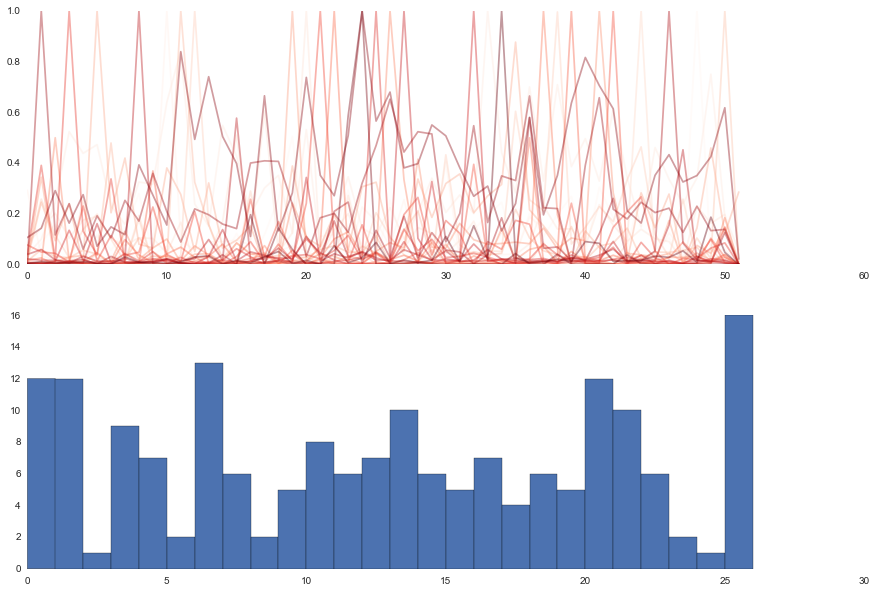

In [70]:
f, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))
col_plt = plt.cm.Reds(np.linspace(0, 1, clust.cluster_centers_.shape[0]))
ax.set_color_cycle(col_plt)
_ = ax.plot(clust.cluster_centers_.T, alpha=.4)

_ = ax2.hist(labels, bins=range(labels.max()+1))

In [54]:
sil = metrics.silhouette_score(X, labels)
print sil

0.113275862237


['AXEXO OE Misc' 'BAHSB ECSM Media Svc' 'BQRES RS Post Award Private'
 'CLLAW Computer Services' 'EERES CITRIS - Gift/Donor'
 'EJMSM MO Central office' 'EKMEG MEO Faculty Funds' 'IMMCB BH Research'
 'IMMCB MCB Technical Facilities' 'IQBBB QB3 Biomoleculr Nano Ctr'
 'IQBBB QB3 MacroLab' 'MMIMS General Ops' 'SZANT Anthro Gen Ops']


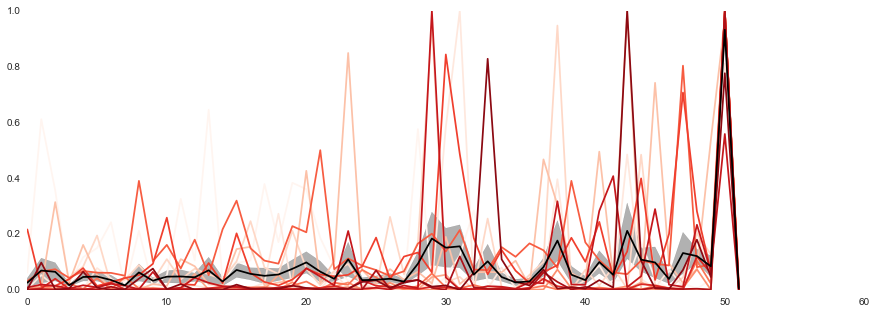

In [75]:
plt_clust = 6
mask_clust = labels == plt_clust
X_sub = X[mask_clust, :].T
names_clust = week_sums_normalized.columns[mask_clust]
n_week, n_sig = X_sub.shape
X_sub_mean = X_sub.mean(1)
X_sub_ste = X_sub.std(1) / np.sqrt(n_sig)

f, ax = plt.subplots(figsize=(15, 5))
col_plt = plt.cm.Reds(np.arange(n_sig) / float(n_sig))
ax.set_color_cycle(col_plt)
_ = ax.plot(X_sub)
_ = ax.plot(X_sub_mean, color='k')
_ = ax.fill_between(range(n_week), 
                    X_sub_mean - X_sub_ste, X_sub_mean + X_sub_ste,
                    color='k', alpha=.3)
print(names_clust.values)

## Correlation matrix

In [36]:
week_sums_corr = week_sums_normalized.corr()

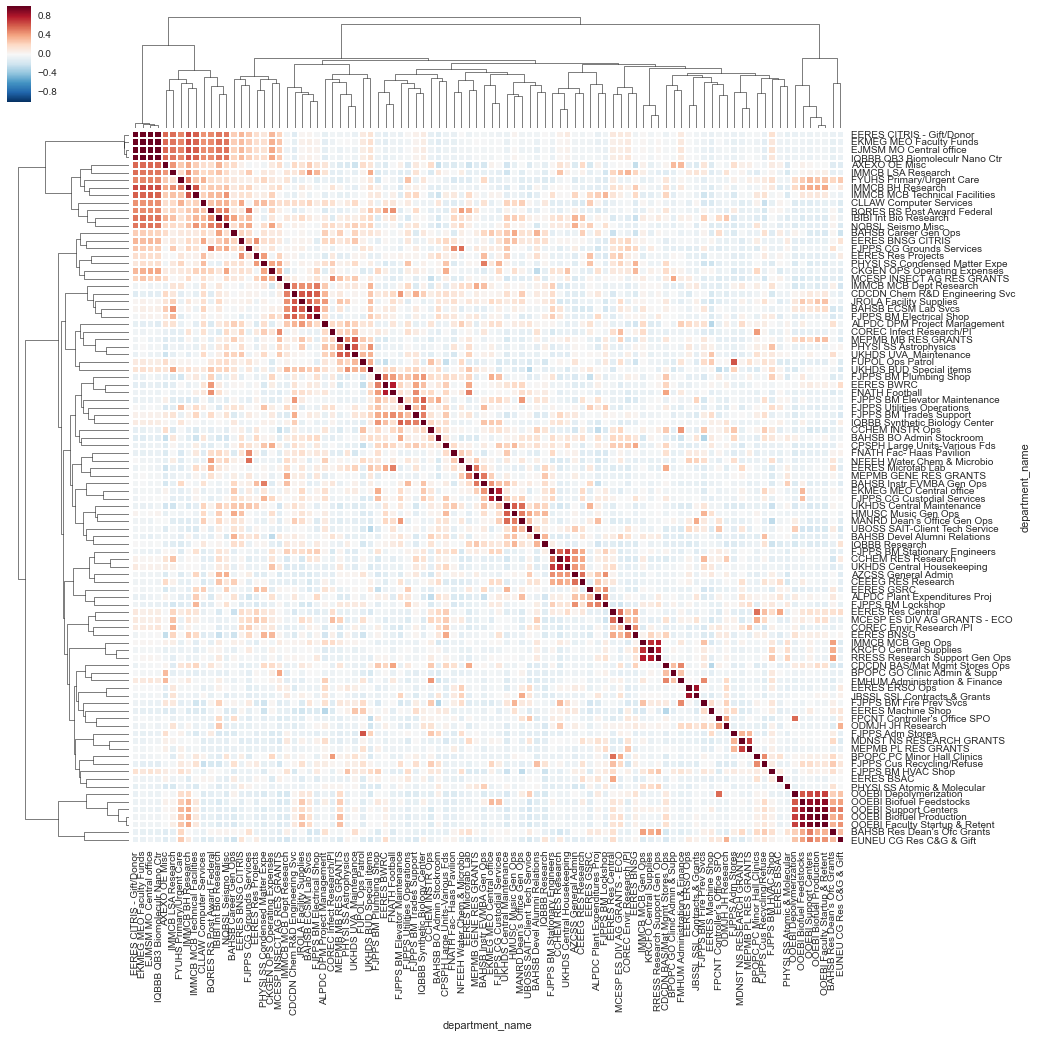

In [38]:
clust = sns.clustermap(week_sums_corr, figsize=(15, 15))